<a href="https://colab.research.google.com/github/farrelrassya/teachingMLDL/blob/main/01.%20Machine%20Learning/07.%20Week%207/Notebook/01XGBoost_data_melb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Learn on how to build and optimize model with **gradient boosting.**

#Introduction
By definition, **ensemble methods** combine the predictions of several models (e.g., several trees, in the case of random forest).

Now, we'll learn about another ensemble method called gradient boosting.

#Difference of Decision Tree, Random Forest, and XGBoost

1. Decision Tree:
A decision tree is a simple and interpretable model that recursively splits the data into subsets based on the feature values. It forms a tree-like structure where each internal node represents a test on a feature, each branch represents the outcome of that test, and each leaf node represents the final prediction. The decision tree makes binary decisions at each node to split the data. It is prone to overfitting, especially when the tree becomes deep, capturing noise and leading to poor generalization on unseen data.

2. Random Forest:
Random Forest is an ensemble learning method that builds multiple decision trees and combines their predictions through voting (for classification) or averaging (for regression). Each decision tree is trained on a random subset of the data (bootstrap sample) and a random subset of the features. This randomness reduces overfitting and increases the model's ability to generalize to new data.

3. XGBoost (Extreme Gradient Boosting):
XGBoost is an optimized implementation of the Gradient Boosting algorithm. It creates an ensemble of weak learners (usually shallow decision trees) sequentially, where each new model corrects the errors made by the previous one. XGBoost uses a gradient-based optimization algorithm to minimize a loss function while adding new trees to the ensemble. It also includes regularization terms to control overfitting and speed up the training process. XGBoost is known for its high performance, scalability, and efficiency, making it popular in various machine learning competitions and real-world applications.
**XGBoost** is an implementation of gradient boosting with several additional features focused on perfmance and speed. The final result of an XGBoost model is a weighted sum of the predictions made by all the individual trees in the sequence. The contribution of each tree is adjusted during training based on how well it reduces the overall error.


Note:

* Regularization (penyederhanaan): XGBoost introduces regularization terms to control overfitting during the training process. Regularization helps prevent the model from becoming too complex and ensures better generalization to unseen data.


#Gradient Boosting

**Gradient boosting** is a method that goes through cycles to iteratively add models into an ensemble (setelan).

It begins by initializing the ensemble with a single model, whose predictions can be pretty naive. (Even if its predictions are wildly inaccurate, subsequent (kemudian) additions to the ensemble will address those errors.)

Then, we start the cycle:
1. First, we use the current ensemble to generate predictions for each observation in the dataset. To make a prediction, we **add the predictions from all models** in the ensemble.
2. These predictions are used to calculate a loss function (like mean squared error, for instance).
3. Then, we use the loss function to fit a new model that will be added to the ensemble. Specifically, we determine model parameters so that adding this new model to the ensemble will reduce the loss.
4. Finally, we add the new model to ensemble, and ...
5. Repeat!

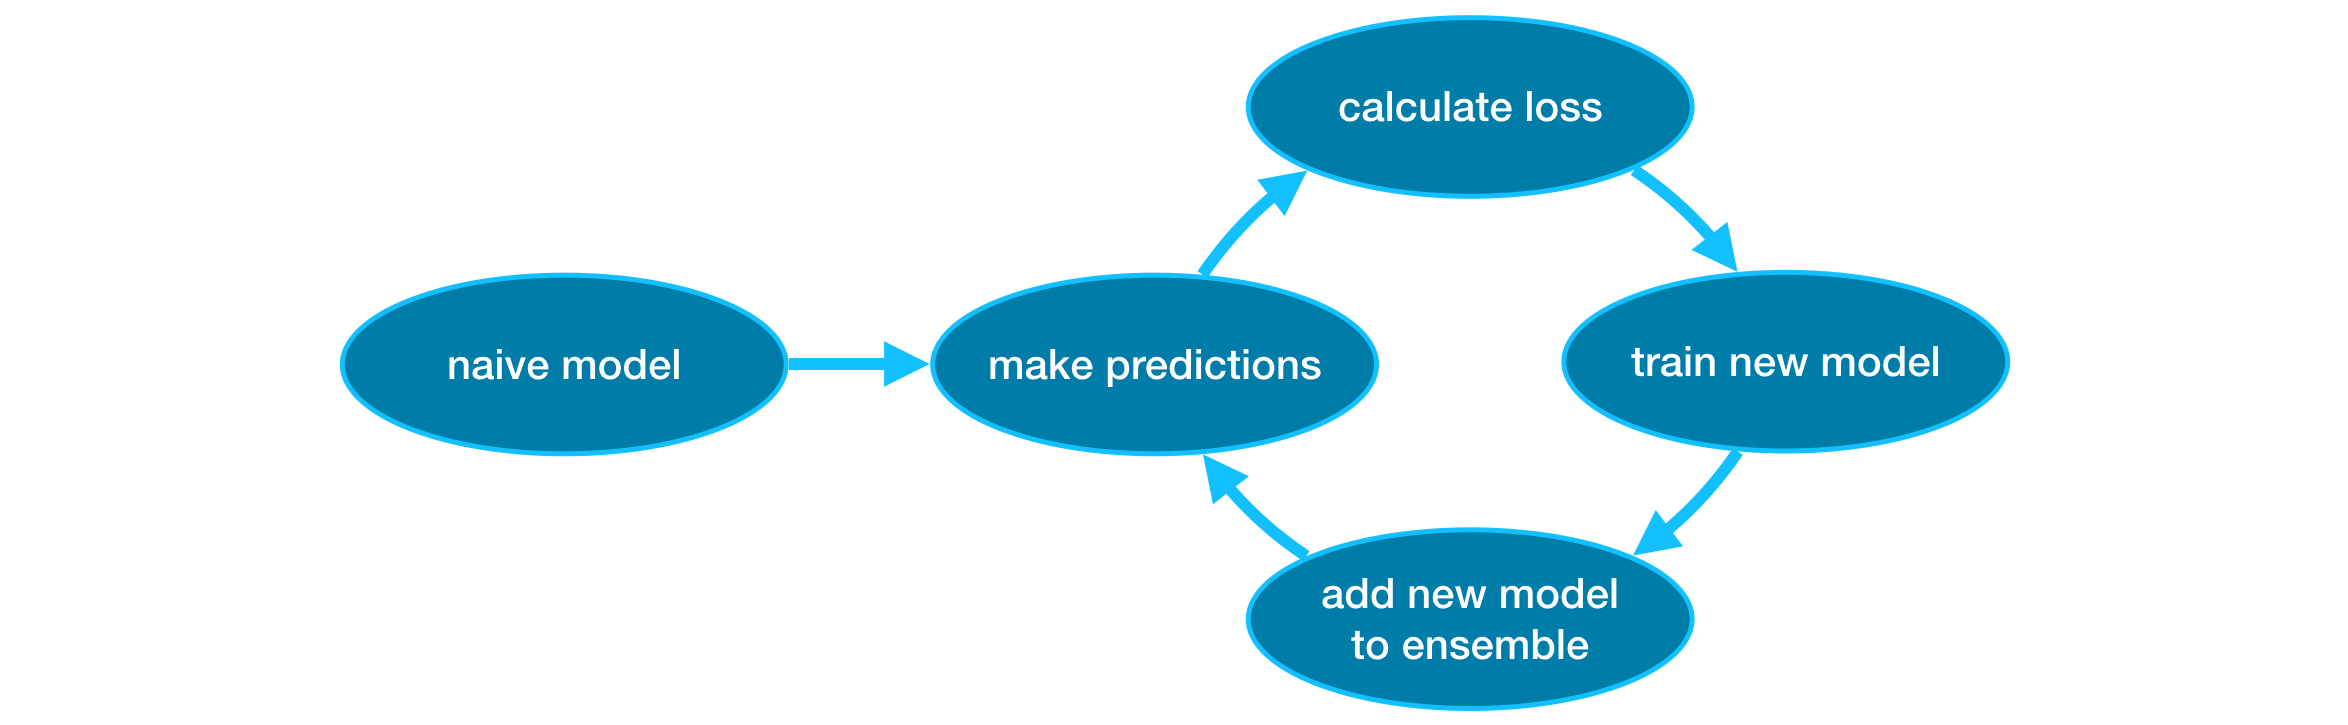

#Example
We begin by loading the training and validation data in X_train, X_valid, y_train, y_valid.

In [1]:
!pip install shap

In [2]:
!pip install -U xgb_classifier

ERROR: Could not find a version that satisfies the requirement xgb_classifier (from versions: none)
ERROR: No matching distribution found for xgb_classifier


In [12]:
import pandas as pd #Untuk penanganan dan manipulasi data.
import numpy as np #Untuk operasi numerik dan penanganan array.
from sklearn.model_selection import train_test_split #Untuk membagi data menjadi bagian pelatihan dan pengujian model.
from sklearn.metrics import mean_absolute_error #Metrik untuk mengevaluasi akurasi model.
import xgboost as xgb #Untuk membangun model prediktif yang akurat dan efisien untuk berbagai tugas machine learning.
import matplotlib.pyplot as plt #Untuk membuat plot dan visualisasi.
from xgboost import XGBRegressor #Model machine learning untuk prediksi (regresi).
import shap #Untuk memahami fitur mana yang paling penting untuk prediksi.
from sklearn.inspection import PartialDependenceDisplay #Untuk memvisualisasikan hubungan antara fitur dan prediksi.
from xgboost import plot_importance #Untuk memvisualisasikan pentingnya fitur dalam model XGBoost yang sudah dilatih.
from xgboost import plot_tree #Untuk memvisualisasikan struktur pohon keputusan dalam model XGBoost yang sudah dilatih.
from sklearn.model_selection import learning_curve #Untuk mengevaluasi kinerja model machine learning dengan variasi ukuran data latih.

**Prompt:**

Write a code cell to mount Google Drive in Colab.

In [14]:
from google.colab import drive
drive.mount('/content/drive')
//Mount Google Drive

SyntaxError: invalid syntax (<ipython-input-14-c92633da75c8>, line 3)

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Prompt:**

Write a code cell to read a CSV file from Google Drive into a DataFrame.

In [18]:
from google.colab import drive
drive.mount('/content/drive')
# Mount Google Drive

file_path = '/content/drive/MyDrive/week 7/tugasxgboost.csv'
df = pd.read_csv(file_path)
#Read CSV file into DataFrame

df.head()
#Menampilkan beberapa baris pertama DataFrame

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,Class
0,7.4,0.70,0.00,1.9,76.0,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,98.0,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,92.0,15.0,54.0,997.0000,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,75.0,17.0,60.0,998.0000,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,76.0,11.0,34.0,0.9978,3.51,0.56,9.4,5


**Prompt:**

Write a code cell to select a subset of predictors ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt'] and set the target variable ['Price'] from the DataFrame.

In [21]:
predictors = ['X1', 'X2', 'X5', 'X6', 'X7']  #Merujuk kepada ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt']
target = 'Class'  #Merujuk kepada 'Price'
#Pilih Subset Prediktor dan Tetapkan Variabel Target

X = df[predictors]
y = df[target]

X.head(), y.head()
#Tampilkan beberapa baris pertama dari prediktor dan target

(     X1    X2    X5    X6    X7
 0   7.4  0.70  76.0  11.0  34.0
 1   7.8  0.88  98.0  25.0  67.0
 2   7.8  0.76  92.0  15.0  54.0
 3  11.2  0.28  75.0  17.0  60.0
 4   7.4  0.70  76.0  11.0  34.0,
 0    5
 1    5
 2    5
 3    6
 4    5
 Name: Class, dtype: int64)

**Prompt:**

Write a code cell to split the data into training and validation

In [22]:
train_data, X_valid, train_labels, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)
#Membagi data menjadi training dan validation set

train_data.shape, X_valid.shape, train_labels.shape, y_valid.shape
#Tampilkan dimensi dari himpunan data hasil

((1279, 5), (320, 5), (1279,), (320,))

In the next code cell, we import the scikit-learn API for XGBoost (`xgboost.XGBRegressor`). As you'll see in the output, the `XGBRegressor` class has many tunable parameters.


**Prompt:**

Write a code cell to train the model using XGBoost, and print the mean absolute error on the validation set.

In [23]:
classifier = XGBRegressor(random_state=42)
classifier.fit(train_data, train_labels)
#Gunakan algoritma XGBoost untuk melatih classifier machine learning.

y_pred = classifier.predict(X_valid)
#Buat prediksi pada set validasi

mae = mean_absolute_error(y_valid, y_pred)
#Hitung mean absolute error pada set validasi

print(f"Mean Absolute Error on the validation set: {mae:.2f}")
#Tampilkan mean absolute error

Mean Absolute Error on the validation set: 0.50


We also make predictions and evaluate the model.

#Parameter Tuning
XGBoost has a few parameters that can dramatically affect accuracy and training speed. The first parameters you should understand are:

`n_estimators`
Specifies how many times to go through the modeling cycle described above. It is equal to the number of models that we include in the ensemble.
* Too low a value causes underfitting, which leads to inaccurate predictions on both training data and test data.
* Too high a value causes overfitting, which causes accurate predictions on training data, but inaccurate predictions on test data (which is what we care about).

Typical values range from 100-1000, though this depends a lot on the `learning_rate` parameter discussed below.

Here is the code to set the number of models in the ensemble:

**Prompt:**

Write a code cell to create another XGBRegressor with 500 estimators, train it, and print the mean absolute error on the validation set.

In [24]:
classifier_500 = XGBRegressor(n_estimators=500, random_state=42)
classifier_500.fit(train_data, train_labels)
#Membuat sebuah classifier XGBRegressor dengan 500 estimato

y_pred_500 = classifier_500.predict(X_valid)
#Buat prediksi pada set validasi

mae_500 = mean_absolute_error(y_valid, y_pred_500)
#Hitung mean absolute error pada set validasi

print(f"Mean Absolute Error on the validation set (500 estimators): {mae_500:.2f}")
#Tampilkan mean absolute error

Mean Absolute Error on the validation set (500 estimators): 0.49


The MAE result of the model with n_estimators set to 500 turned out to be greater than the default value of n_estimators, which is 100.

The MAE (Mean Absolute Error) of the model with an n_estimators value of 110 turns out to be smaller than the default n_estimators value of 100, as well as n_estimators with a value of 500.

`early_stopping_rounds`
offers a way to automatically find the ideal value for `n_estimators`. Early stopping causes the model to stop iterating when the validation score stop improving, even if we aren't the hard stop for `n_estimators`. It's smart to set a high value for `n_estimators` and then use `early_stopping_rounds` to find the optimal time to stop iterating.

Since random chance sometimes causes a single round where validation scores don't improve, you need to specify a number for how many rounds of straight deterioration (keburukan) to allow before stopping. Setting `early_stopping_rounds=5` is a reasonable choice. In this case, we stop after 5 straight rounds of deteriorating validation scores.

When using `early_stopping_rounds`, you also need to set aside some data for calculating the validation scores. This is done by setting the `eval_set` parameter.

We can modify the example above to include early stopping.

---
Note:

* In the context of training machine learning models, "deteriorating" refers to a situation where the performance of the model on a validation dataset worsens over consecutive iterations during the training process. Typically, we monitor a metric (such as accuracy, mean squared error, etc.) on the validation dataset to evaluate the model's performance.

* In the given code, verbose=False is an argument passed to the fit method of the XGBRegressor model. Setting verbose to False means that during the training process, the model will not produce any output or progress messages. It will train silently without displaying information about each boosting round.

`n_jobs`

On larger datasets where runtime is a consideration, you can use parallelism to build your model faster. It's common to set the parameter `n_jobs` equal to the number of cores on your machine. On smaller datasets, this won't help.
The resulting model won't be any better, so micro-optimizing for fitting time is typically nothing but a distraction. But, it's useful in large datasets where you would otherwise spend a long time waiting during the `fit` command.

Here's the modified example.

**Prompt:**

Write a code cell to train an XGBRegressor with a custom learning rate, 90 estimators, and early stopping rounds, and print the mean absolute error on the validation set.

In [25]:
classifier_custom = XGBRegressor(n_estimators=90, learning_rate=0.05, random_state=42)
#Membuat sebuah classifier XGBRegressor dengan learning rate kustom dan 90 estimator

classifier_custom.fit(train_data, train_labels, eval_set=[(X_valid, y_valid)], verbose=False)
##Melatih classifier menggunakan training set tanpa early stopping

y_pred_custom = classifier_custom.predict(X_valid)
#Buat prediksi pada set validasi

mae_custom = mean_absolute_error(y_valid, y_pred_custom)
#Hitung mean absolute error pada set validasi

print(f"Mean Absolute Error on the validation set (custom classifier): {mae_custom:.2f}")
#Tampilkan mean absolute error

Mean Absolute Error on the validation set (custom classifier): 0.52


## Visualisasi Feature Importance


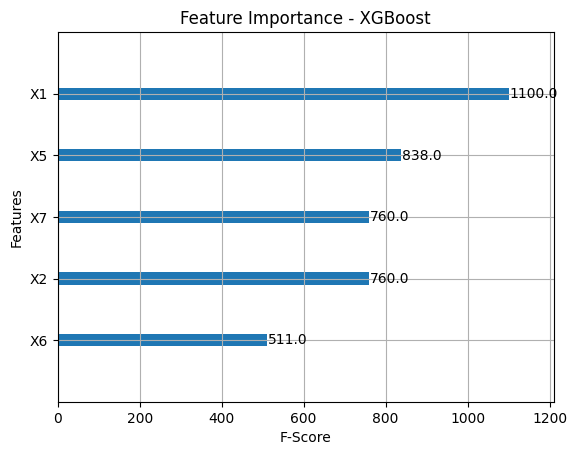

In [27]:
classifier_custom = XGBRegressor(n_estimators=90, learning_rate=0.05, random_state=42)
#Membuat sebuah classifier XGBRegressor dengan learning rate kustom dan 90 estimator

classifier_custom.fit(train_data, train_labels)
#Melatih classifier menggunakan data training

plot_importance(classifier_custom, importance_type='weight')
plt.title('Feature Importance - XGBoost')
plt.xlabel('F-Score')
plt.ylabel('Features')
plt.show()
#Visualisasi feature importance

## Visualisasi struktur pohon

<Figure size 5000x2000 with 0 Axes>

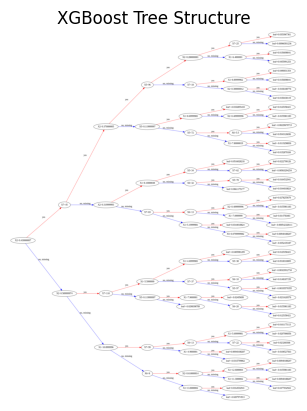

In [28]:
classifier_custom = XGBRegressor(n_estimators=90, learning_rate=0.05, random_state=42)
classifier_custom.fit(train_data, train_labels)
#Melatih kembali classifier XGBoost.

plt.figure(figsize=(50, 20))
plot_tree(classifier_custom, num_trees=0, rankdir='LR')
plt.title('XGBoost Tree Structure')
plt.show()
#Memvisualisasikan struktur pohon

##Visualisasi Learning Curve


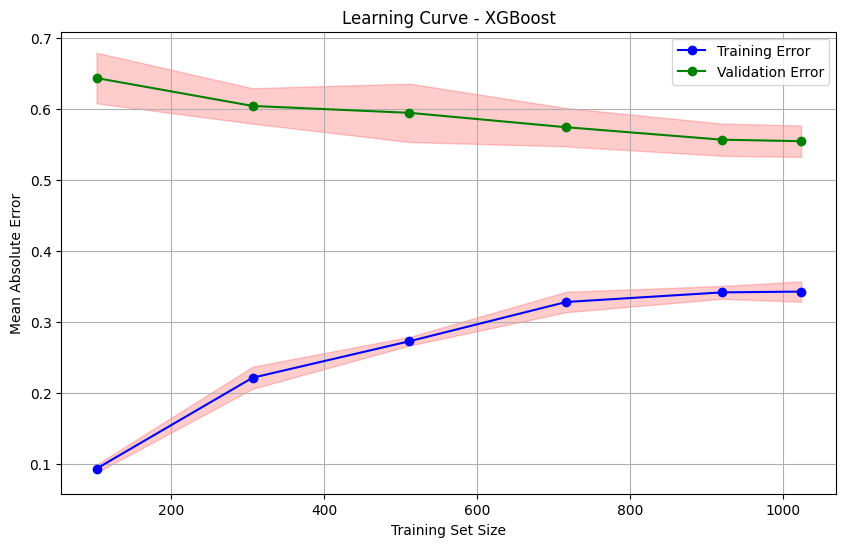

In [29]:
classifier_custom = XGBRegressor(n_estimators=90, learning_rate=0.05, random_state=42)
classifier_custom.fit(train_data, train_labels)
#Melatih kembali classifier XGBoost.

train_sizes, train_scores, valid_scores = learning_curve(
    estimator=classifier_custom,
    X=train_data,
    y=train_labels,
    train_sizes=[0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    cv=5,
    scoring='neg_mean_absolute_error'
)
#Hasil data learning curve.

train_mean = -train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
valid_mean = -valid_scores.mean(axis=1)
valid_std = valid_scores.std(axis=1)
#Menghitung nilairata-rata dan deviasi standar untuk skor pelatihan dan validasi.

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Error')
plt.plot(train_sizes, valid_mean, 'o-', color='green', label='Validation Error')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='red')
plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, alpha=0.2, color='red')
#Memvisulasisasikan learning curve

plt.title('Learning Curve - XGBoost')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid()
plt.show()

## Visualisasi Shap Values


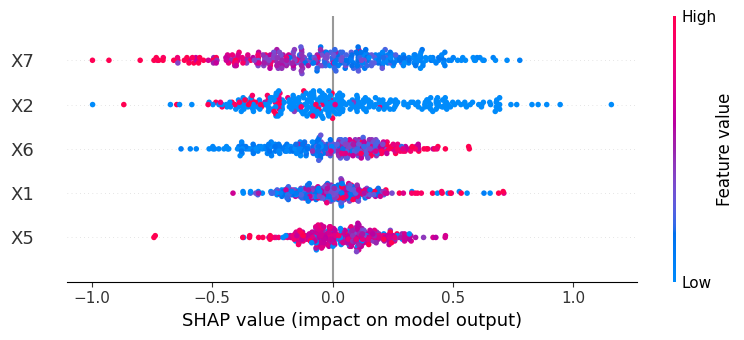

In [30]:
explainer = shap.Explainer(classifier, train_data)
shap_values = explainer(X_valid)
#Inisialisasi SHAP explainer

shap.summary_plot(shap_values, X_valid)
#Menampilkan plot SHAP values

## Visualisasi Partial Dependence Plot


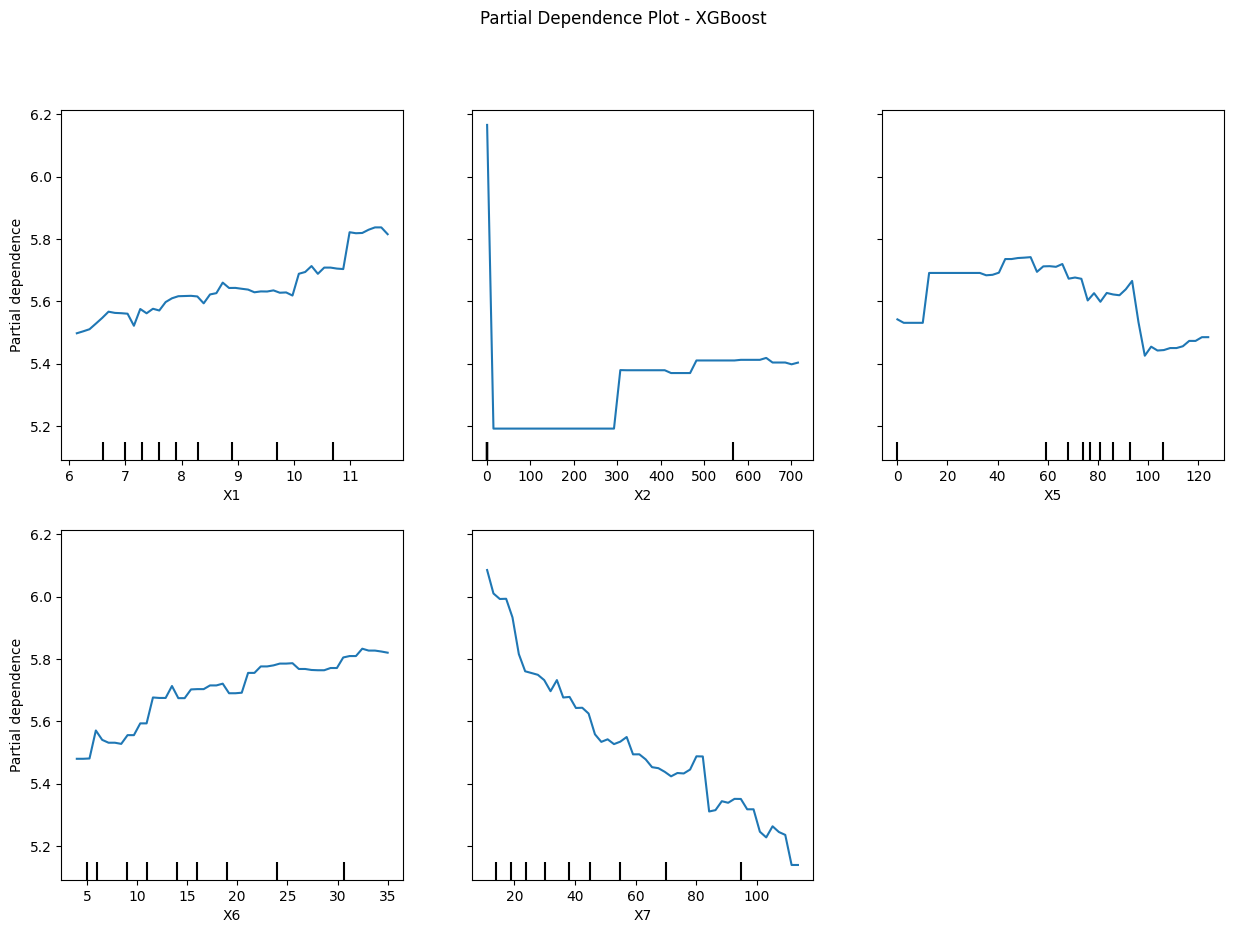

In [31]:
classifier_custom = XGBRegressor(n_estimators=90, learning_rate=0.05, random_state=42)
classifier_custom.fit(train_data, train_labels)
#Melatih classifier XGBoost.

fig, ax = plt.subplots(figsize=(15, 10))
PartialDependenceDisplay.from_estimator(
    classifier_custom,
    train_data,
    features=[0, 1, 2, 3, 4],
    grid_resolution=50,
    ax=ax
)
plt.suptitle('Partial Dependence Plot - XGBoost')
plt.show()
#Membuat visualisasi partial dependence plot